In [1]:
import pandas as pd
import numpy as np
import os
from ete3 import NCBITaxa
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
DATA_PATH = '../data'
FILENAME = '20231220.csv'
figure_folder = 'Jan_8_2024'


In [3]:
metadata_df = pd.read_csv(os.path.join(DATA_PATH, FILENAME), header=1)


# Get Kingdom and Superkingdom of Organism 

In [4]:
ncbi = NCBITaxa()
lineage_superkingdom = [None]*metadata_df.shape[0]
lineage_kingdom = [None]*metadata_df.shape[0]
for index, row in metadata_df.iterrows():
    try:
        tax_id = row['organism.term accession number'].split('/')[-1]
        lineage = ncbi.get_lineage(tax_id)
        lineage_names = ncbi.get_taxid_translator(lineage)
        for item in lineage_names:
            rank = list(ncbi.get_rank([item]).values())[0]
            if rank == 'superkingdom':
                lineage_superkingdom[index] = lineage_names[item]
            if rank == 'kingdom':
                lineage_kingdom[index] = lineage_names[item]
    except:
        continue
metadata_df.loc[:, 'lineage_superkingdom'] = lineage_superkingdom
metadata_df.loc[:, 'lineage_kingdom'] = lineage_kingdom


# Include only GeneLab processed data

In [5]:
metadata_df = metadata_df[metadata_df['GL-processed']!='False']
metadata_df.accession.unique().shape

(211,)

# Count of study assay technology type

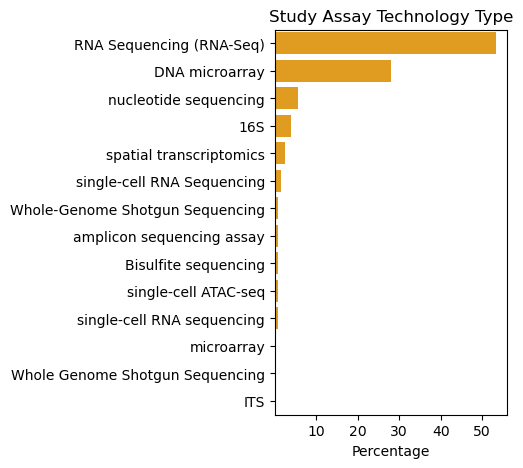

In [6]:
counts = metadata_df['study assay technology type'].value_counts()

total_samples = len(metadata_df)
percentage = (counts / total_samples) * 100

sorted_categories = percentage.index
sorted_percentages = percentage.values

fig = plt.figure(figsize=(3, 5))
sns.barplot(x=sorted_percentages, y=sorted_categories, color='orange', order=sorted_categories)

plt.title('Study Assay Technology Type')
plt.xlabel('Percentage')
plt.ylabel('')
plt.xticks(range(10, 51, 10))

plt.show()

fig.savefig('../data/figures/{}/assay_type.svg'.format(figure_folder), format="svg", bbox_inches='tight')


In [7]:

spoke_relevant_assays = ['RNA Sequencing (RNA-Seq)', 'DNA microarray', 'mass spectrometry', 'nucleotide sequencing', '16S']
metadata_df_ = metadata_df[metadata_df['study assay technology type'].isin(spoke_relevant_assays)]
metadata_df[metadata_df['study assay technology type'].isin(spoke_relevant_assays)].accession.unique().shape



(194,)

# Organism counts

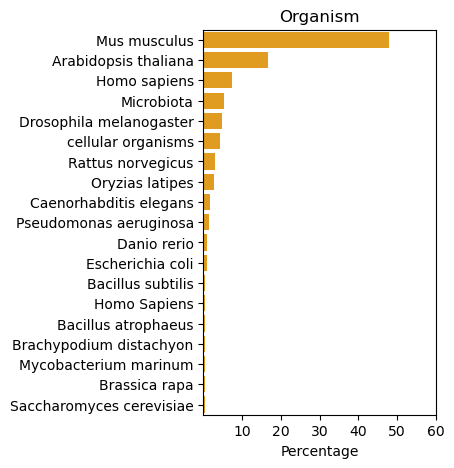

In [8]:
counts = metadata_df_['organism'].value_counts()

total_samples = len(metadata_df_)
percentage = (counts / total_samples) * 100

sorted_categories = percentage.index
sorted_percentages = percentage.values

fig = plt.figure(figsize=(3, 5))
sns.barplot(x=sorted_percentages, y=sorted_categories, color='orange', order=sorted_categories)

plt.title('Organism')
plt.xlabel('Percentage')
plt.ylabel('')
plt.xticks(range(10, 61, 10))

plt.show()

fig.savefig('../data/figures/{}/organism_type_after_assay_filtering.svg'.format(figure_folder), format="svg", bbox_inches='tight')


## Exclude organisms that are Plants or Fungi

In [9]:
organism_to_exclude = ['Viridiplantae', 'Fungi']
metadata_df_without_plants_fungi = metadata_df_[~metadata_df_['lineage_kingdom'].isin(organism_to_exclude)]
metadata_df_without_plants_fungi = metadata_df_without_plants_fungi[metadata_df_without_plants_fungi.organism != 'Not Applicable']
metadata_df_without_plants_fungi.dropna(subset=['lineage_kingdom'], inplace=True)
metadata_df_without_plants_fungi.dropna(subset=['organism'], inplace=True)
metadata_df_without_plants_fungi.accession.unique().shape


(127,)

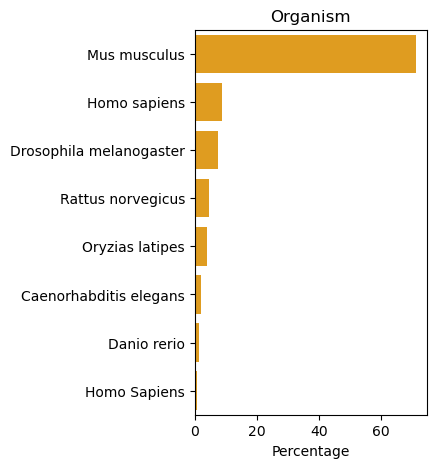

In [10]:
counts = metadata_df_without_plants_fungi['organism'].value_counts()

total_samples = len(metadata_df_without_plants_fungi)
percentage = (counts / total_samples) * 100

sorted_categories = percentage.index
sorted_percentages = percentage.values

fig = plt.figure(figsize=(3, 5))
sns.barplot(x=sorted_percentages, y=sorted_categories, color='orange', order=sorted_categories)

plt.title('Organism')
plt.xlabel('Percentage')
plt.ylabel('')
# plt.xticks(range(10, 61, 10))

plt.show()

fig.savefig('../data/figures/{}/organism_type_after_selection.svg'.format(figure_folder), format="svg", bbox_inches='tight')



# Count of Material type used for the study

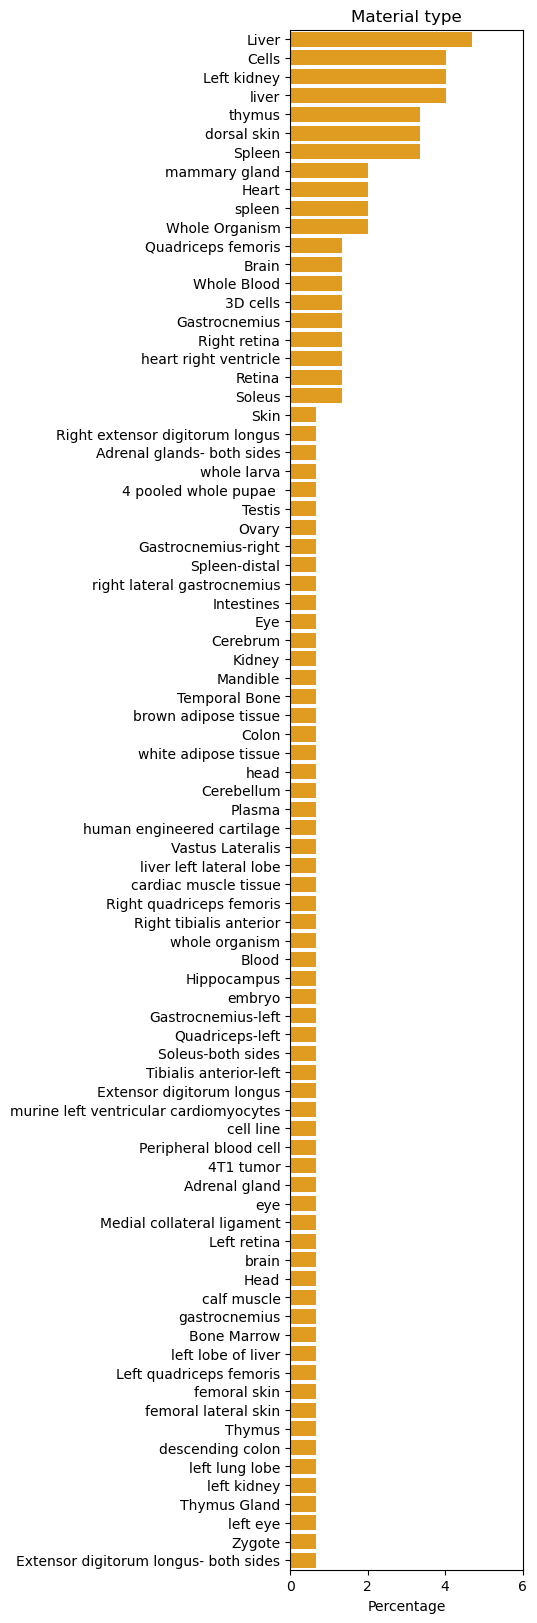

In [11]:
counts = metadata_df_without_plants_fungi['material type'].value_counts()

total_samples = len(metadata_df_without_plants_fungi)
percentage = (counts / total_samples) * 100

sorted_categories = percentage.index
sorted_percentages = percentage.values

fig = plt.figure(figsize=(3, 20))
sns.barplot(x=sorted_percentages, y=sorted_categories, color='orange', order=sorted_categories)

plt.title('Material type')
plt.xlabel('Percentage')
plt.ylabel('')
plt.xticks(range(0, 7, 2))

plt.show()

fig.savefig('../data/figures/{}/material_type_after_organism_filter.svg'.format(figure_folder), format="svg", bbox_inches='tight')


In [12]:
metadata_df_without_plants_fungi_ = metadata_df_without_plants_fungi.dropna(subset=['material type.term accession number'])
metadata_df_without_plants_fungi_.loc[:,'material_type_id'] = metadata_df_without_plants_fungi_['material type.term accession number'].apply(lambda x:x.split('/')[-1].split('_')[0])

metadata_df_without_plants_fungi_after_uberon_filter = metadata_df_without_plants_fungi_[(metadata_df_without_plants_fungi_.material_type_id.str.startswith('D')) | 
                                   (metadata_df_without_plants_fungi_.material_type_id == 'UBERON') |
                                 (metadata_df_without_plants_fungi_['material_type_id'].str.contains('fma'))|
                                 (metadata_df_without_plants_fungi_['material_type_id'].str.contains('EHDA')) |
                                 (metadata_df_without_plants_fungi_['material_type_id'].str.contains('owl'))]

metadata_df_without_plants_fungi_after_uberon_filter.accession.unique().shape


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_1314/3205977450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_without_plants_fungi_.loc[:,'material_type_id'] = metadata_df_without_plants_fungi_['material type.term accession number'].apply(lambda x:x.split('/')[-1].split('_')[0])


(84,)

In [13]:
metadata_df_without_plants_fungi_after_uberon_filter[metadata_df_without_plants_fungi_after_uberon_filter.accession=='OSD-1']


,accession,assay name,sample count,GL-processed,non-GL-processed,study assay technology type,material type,material type.term accession number,material type.term source ref,organism,...,uv mutagenesis,vaccine adjuvant,variation,water deprivation,weightlessness,weightlessness simulation,zygosity,lineage_superkingdom,lineage_kingdom,material_type_id
0,OSD-1,OSD-1_transcription-profiling_dna-microarray,18,GeneLab Processed Microarray Data Files,False,DNA microarray,whole organism,http://purl.obolibrary.org/obo/UBERON_0000468,EFO,Drosophila melanogaster,...,False,False,False,False,False,False,False,Eukaryota,Metazoa,UBERON


In [14]:
metadata_df_without_plants_fungi_after_uberon_filter['sample count'].sum()

2910

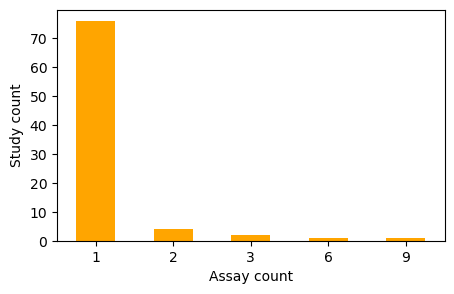

In [15]:

counts = metadata_df_without_plants_fungi_after_uberon_filter['accession'].value_counts()

fig = plt.figure(figsize=(5, 3))
counts.value_counts().sort_index().plot(kind='bar', color='orange')

plt.xlabel('Assay count')
plt.ylabel('Study count')
plt.xticks(rotation=0)
plt.show()

fig.savefig('../data/figures/{}/Study_vs_Assay_count.svg'.format(figure_folder), format="svg", bbox_inches='tight')



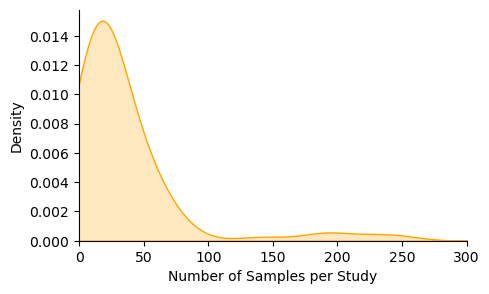

In [16]:

counts = metadata_df_without_plants_fungi_after_uberon_filter.groupby('accession')['sample count'].sum()

fig = plt.figure(figsize=(5, 3))
sns.kdeplot(counts, fill=True, color='orange')
# sns.histplot(counts, kde=False)

plt.xlabel('Number of Samples per Study')
plt.ylabel('Density')
plt.xlim(0, 300)
sns.despine(top=True, right=True)
plt.show()

fig.savefig('../data/figures/{}/number_of_samples_distribution.svg'.format(figure_folder), format="svg", bbox_inches='tight')


In [17]:
metadata_df_without_plants_fungi_after_uberon_filter[metadata_df_without_plants_fungi_after_uberon_filter['accession'] == 'OSD-462']['assay name'].values


array(['OSD-462_transcription-profiling_rna-sequencing-(rna-seq)_illumina-mrna',
       'OSD-462_transcription-profiling_rna-sequencing-(rna-seq)_illumina-totrna',
       'OSD-462_transcription-profiling_rna-sequencing-(rna-seq)_illumina-upx'],
      dtype=object)

In [18]:
list(metadata_df_without_plants_fungi_after_uberon_filter.columns)

['accession',
 'assay name',
 'sample count',
 'GL-processed',
 'non-GL-processed',
 'study assay technology type',
 'material type',
 'material type.term accession number',
 'material type.term source ref',
 'organism',
 'organism.term accession number',
 'organism.term source ref',
 'absorbed radiation dose',
 'accession.1',
 'age',
 'age at sample harvest',
 'altered gravity',
 'altered gravity simulator',
 'altitude',
 'animal housing',
 'antibiotic concentration',
 'atmospheric pressure',
 'bed rest',
 'bleomycin treatment',
 'cage',
 'carcass preservation method',
 'cell cycle phase',
 'cell line',
 'clinical treatment',
 'collection date',
 'collection set',
 'cultivar',
 'culture condition',
 'culture media',
 'developmental condition',
 'developmental stage',
 'diet',
 'dissection condition',
 'dissection timeline',
 'donor',
 'dose',
 'dry immersion',
 'duration',
 'ecotype',
 'electromagnetic fields',
 'environmentalstress',
 'euthanasia location',
 'euthanasia method',
 'ex

## Loading data with URL information

In [30]:
data_with_url = pd.read_csv(os.path.join(DATA_PATH, '20240131-file-urls.csv'), header=1)
data_with_url.shape

(133891, 8)

## Selecting rows corresponding to the selected study-ids and saving the file

In [34]:
data_with_url[data_with_url.accession.isin(metadata_df_without_plants_fungi_after_uberon_filter.accession)].to_csv(os.path.join(DATA_PATH, '20240131_file_urls_with_selected_study_ids.csv'), index=False, header=True)

